In [ ]:
"""
This notebook generates all data found in the paper.
On a newish laptop, it should run in ~20 minutes.
"""



from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle


import models

import matplotlib.pyplot as plt

In [2]:
def fn(n):
    return "../data/fig_"+str(n)+".pkl"


g = 432
I0 = 5
S_E = 1.44
S_I = 0.72
m0 = 864*10

common_params = dict(m_0 = m0, M=0, S_E=S_E, S_I=S_I, I_0=I0, γ=g, f_K=np.sqrt(20000), f_n=2)
uncommon_params = {}
uncommon_params["A"] = dict(k_r=1/24, g_K=4000, g_n=2, g_k=116)
uncommon_params["B"] = dict(k_r=1/24, g_K=4000, g_n=2, g_k=1700)
uncommon_params["C"] = dict(k_r=1/36, g_K=4000, g_n=2, g_k=1700*1.5)


#set beta_tot to give fasting G of 110 before the emergency
for key in ["A", "B", "C"]:
    params = dict(G_0=110.0, **common_params, **uncommon_params[key] )
    B0 = g*models.adaptive_beta(params)
    uncommon_params[key]["beta_tot"] = B0
        

small_meal_rate = 300.0
large_meal_rate = 8500.0
insulin_rate = 70.0*g/100 

def fig_2_data(params_A, params_B, params_C, params_D, sp_A, sp_B, sp_C, sp_D):
    g_A = models.full_simulation(params_A,**sp_A)[0]
    g_B = models.full_simulation(params_B, **sp_B)[0]
    g_C = models.full_simulation(params_C, **sp_C)[0]
    temp = models.full_simulation(params_D, **sp_D)
    g_D, t = temp[0], temp[-1]
    
    with open(fn(2), "wb") as f:
        pickle.dump(dict(t=t, A=dict(G=g_A, sp=sp_A), B=dict(G=g_B, sp=sp_B), C=dict(G=g_C, sp=sp_C), D=dict(G=g_D, sp=sp_D)), f)
    


def fig_3_data(params_A, params_B):
    #fasting_beta_rates_B = models.intermediate_rates(params_B, meal_insulin_schedule=[(1.0,0.0, 0.0)], resolution=0.01)
    #fasting_beta_rates_A = models.intermediate_rates(params_A, meal_insulin_schedule=[(1.0,0.0, 0.0)], resolution=0.01)
    B0 = params_B['beta_tot']
    A = models.r_table(params_A, a_list = jnp.array([0.0]), SI_range=[S_I, 116], SI_samples=1, beta_range=[0.001, B0], beta_samples=3000)

    B = models.r_table(params_B, a_list = jnp.array([0.0]), SI_range=[S_I, 116], SI_samples=1, beta_range=[0.001, B0], beta_samples=3000)
    with open(fn(3), "wb") as f:
        pickle.dump(dict(A=dict(b=A['beta'].values/ B0, d=params_A['k_r']*((1-A['beta'].values/ B0) - A['r'].values*(A['beta'].values/ B0)) ),
                         B=dict(b=B['beta'].values/ B0, d=params_B['k_r']*((1-B['beta'].values/ B0) - B['r'].values*(B['beta'].values/ B0) ))), f)
        
def fig_4_data(params_A, params_B,insulin_rate):

    
    B0_B = params_B['beta_tot']

    rates = models.r_table(params_B, a_list = jnp.array([small_meal_rate, large_meal_rate,]), SI_range=[S_I, 116], SI_samples=1, beta_range=[0.001, 3*B0_B], beta_samples=3000)
    rates_I = models.r_table(params_B, a_list = jnp.array([small_meal_rate]), F_I=insulin_rate, SI_range=[S_I, 116], SI_samples=1, beta_range=[0.001, 3*B0_B], beta_samples=3000)


    output = {}
    output["A"] = {}
    output["B"] = {}

    s_small = rates[rates['a']==small_meal_rate]
    s_large = rates[rates['a']==large_meal_rate]
    s_I = rates_I

    s_small = s_small[s_small['beta'] <= B0_B]
    s_large = s_large[s_large['beta'] <= B0_B]
    s_I = s_I[s_I['beta'] <= B0_B]


    output["B"]["normal"] = dict(b=s_small['beta'].values/ B0_B, d= params_B['k_r']*((1-s_small['beta'].values/ B0_B) - s_small['r'].values*(s_small['beta'].values/ B0_B)))
    output["B"]["sugar"] = dict(b=s_large['beta'].values/ B0_B, d= params_B['k_r']*((1-s_large['beta'].values/ B0_B) - s_large['r'].values*(s_large['beta'].values/ B0_B)))
    output["B"]["insulin"] = dict(b=s_I['beta'].values/ B0_B, d=params_B['k_r']*((1-s_I['beta'].values/ B0_B) - s_I['r'].values*(s_I['beta'].values/ B0_B)))

    rates = models.r_table(params_A, a_list = jnp.array([small_meal_rate, large_meal_rate]), SI_range=[S_I, 116], SI_samples=1, beta_range=[0.001, 3*B0_B], beta_samples=3000)
    s_small = rates[rates['a']==small_meal_rate]
    s_large = rates[rates['a']==large_meal_rate]
    s_small = s_small[s_small['beta'] <= B0_B]
    s_large = s_large[s_large['beta'] <= B0_B]

    output["A"]["normal"] = dict(b=s_small['beta'].values/ B0_B, d= params_A['k_r']*((1-s_small['beta'].values/ B0_B) - s_small['r'].values*(s_small['beta'].values/ B0_B)))
    output["A"]["sugar"] = dict(b=s_large['beta'].values/ B0_B, d= params_A['k_r']*((1-s_large['beta'].values/ B0_B) - s_large['r'].values*(s_large['beta'].values/ B0_B)))

    with open(fn(4), "wb") as f:
        pickle.dump(output, f)
        
def fig_5_data(params_A, params_B):
    B0_B = params_B['beta_tot']

    data = {}
    data['A'] = models.SI_beta_scan(params_A, SI_range=[0.1, 3.0], beta_range=[0, 3*B0_B], SI_samples=100,beta_samples=100, G_0=80,a=0.0)
    data['B'] = models.SI_beta_scan(params_B, SI_range=[0.1, 3.0], beta_range=[0, 3*B0_B], SI_samples=100,beta_samples=100, G_0=80,a=0.0,table_beta_samples=6000)

    with open(fn(5), "wb") as f:
        pickle.dump(data, f)
        


In [3]:
%%time 
params_A = dict(**common_params, **uncommon_params["A"], k_d=1e-3)    
params_A['β'] = params_A['beta_tot']  / params_A['γ']
params_B = dict(**common_params, **uncommon_params["B"], k_d=1e-3)
params_B['β'] = params_B['beta_tot']  / params_B['γ']
params_C = dict(**common_params, **uncommon_params["C"], k_d=1e-3)
params_C['β'] = params_C['beta_tot']  / params_C['γ']
params_D = dict(**common_params, **uncommon_params["C"], k_d=7*1e-2)
params_D['β'] = params_D['beta_tot']  / params_D['γ']

sp_default = dict(pre_sugar_days=14, sugar_days=28, post_sugar_days=7, insulin_days=28, post_insulin_days=140,low_sugar=small_meal_rate, high_sugar=large_meal_rate, insulin=insulin_rate)
sim_params = {}
for key, extra_insulin_days in zip(["A", "B","C","D"], [-28, 0, 28, 56]):
    sim_params[key] = dict(sp_default,insulin_days=sp_default["insulin_days"]+extra_insulin_days, post_insulin_days=sp_default["post_insulin_days"]-extra_insulin_days)

fig_2_data(params_A, params_B, params_C, params_D, sim_params["A"], sim_params["B"], sim_params["C"], sim_params["D"])
fig_3_data(params_A, params_B)
fig_4_data(params_A, params_B, insulin_rate)
blah = fig_5_data(params_A, params_B)


CPU times: user 15min 41s, sys: 6.4 s, total: 15min 47s
Wall time: 15min 51s


In [4]:
#check rate of β-cell decline at 150 mg/dL glucose, as mentioned in discussion
models.evaluate(models.hill(params_B["g_K"], params_B["g_n"], params_B["g_k"]*params_B["k_r"]), 150.0)

0.09946949602122016

In [10]:
#estimate grams of sugar produced per day if rate = 2 mg/(kg min), then estimate corresponding rate in units of mg/(dL day)
#for discussion in methods section
rate = 2
body_mass = 70
minutes_in_day = 24*60
grams_per_mg = 0.001
print("rough amount of sugar produced per day (grams):",rate*body_mass*minutes_in_day*grams_per_mg)

body_plasma = 35 #3.5 L, in dL
print("rough HGP rate", rate*body_mass*minutes_in_day/body_plasma)



rough amount of sugar produced per day (grams): 201.6
rough HGP rate 5760.0


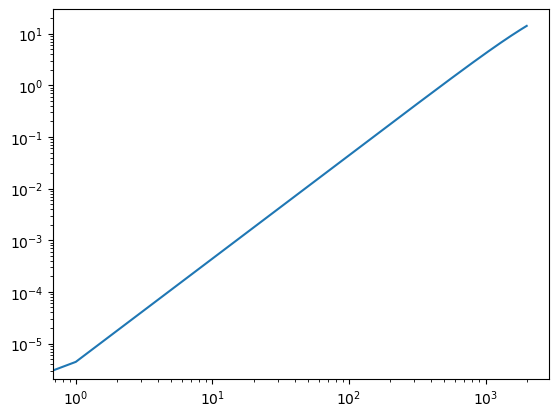